In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics
import dabest
from skimage.io import imread
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from scipy.stats import shapiro, normaltest, kruskal, mannwhitneyu, levene


### Cleaning up the data from Mock Screen 1 (MS1)
<p>The data from the mock screen was captured on 2 different days. All compounds for MS1 were blinded and need to be unblinded before combining with the data from MS2.</p>

In [38]:
#Reading in the analysis summary for the the first mock screen day
MS1_sum = pd.read_csv('C:/Users/Emily/Documents/MS/ia/MS1.csv', index_col=0).drop(columns='Large Object')
MS1_sum.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID
0,1A,324.0,0.132867,NaN,NaN,MS1_006,3028.0,NaN
1,1B,266.0,0.044643,NaN,NaN,MS1_006,3019.0,NaN
2,1C,209.0,0.067416,NaN,NaN,MS1_006,3009.0,NaN
3,1D,343.0,-0.082508,NaN,NaN,MS1_006,3013.0,NaN
4,2A,194.0,0.793103,NaN,NaN,MS1_006,3049.0,NaN


In [39]:
#Reading in the metadata file for the first mock screen day
MS1_md = pd.read_csv('C:/Users/Emily/Documents/MS/data/20210812_metadata.csv', index_col=0)
MS1_md.head()

,Recorder,Plate ID,Different strains in each well of a single assay plate? (Y/N),Different compounds in each well of a single assay plate? (Y/N),Compound library ID,Compound Well A,Compound Well B,Compound Well C,Compound Well D,Temp (C),Humidity,Chemotaxis Start (24 hrs format),Chemotaxis End (24 hrs format),Image ID,Scanner Slot:,Scanner #,Strain Well A,Strain Well B,Strain Well C,Strain Well D
Date:,,,,,,,,,,,,,,,,,,,,
08/12/21,Emily,MS1_R1_001,N,Y,1-1,B2,B3,B4,B5,NaN,NaN,NaN,NaN,MS1_001,1,NaN,NaN,NaN,NaN,NaN
08/12/21,Hodan,MS1_R1_008,N,Y,1-2,B2,B3,B4,B5,NaN,NaN,NaN,NaN,MS1_002,4,NaN,NaN,NaN,NaN,NaN
08/12/21,Emily,MS1_R1_002,N,Y,1-1,C2,C3,C4,C5,NaN,NaN,NaN,NaN,MS1_001,2,NaN,NaN,NaN,NaN,NaN
08/12/21,Emily,MS1_R1_003,N,Y,1-1,D2,D3,D4,D5,NaN,NaN,NaN,NaN,MS1_001,3,NaN,NaN,NaN,NaN,NaN
08/12/21,EMILY,MS1_R1_004,N,Y,1-1,E2,E3,E4,E5,NaN,NaN,NaN,NaN,MS1_001,4,NaN,NaN,NaN,NaN,NaN


### Cleaning up the blinding key to unblind the compounds

In [40]:
compound_data = pd.read_csv('C:/Users/Emily/Documents/MS/compounds/comp_plate_map.csv', index_col=0)

# The compound well info wass "flipped" in the original blinding key and needs to match how the data
# was entered in the metadata sheet

def flip(row):
    id = row['Compound Well']
    flipped = id[::-1]
    #print(flipped)
    return(flipped)

compound_data['Compound Well']=compound_data.apply(
    lambda row: flip(row), axis=1)


In [41]:
# Adding the plate ID to the image analysis results
def add_pid(row, image_metdat):
    slot = row['WellNo'][0]
    pid = image_metdat.loc[(image_metdat['Image ID']==row['File Name']) 
                           & (image_metdat['Scanner Slot:'].astype(str)==slot)]['Plate ID']
    return pid.values[0]

MS1_sum['Plate ID']=MS1_sum.apply(
    lambda row: add_pid(row, MS1_md), axis=1)


In [42]:
# Creating a function to map the compound info in the metadata sheet to the automated image 
# analysis results. The compound is still blinded at this point
def f(x):
    return {
        'A': 'Compound Well A',
        'B': 'Compound Well B',
        'C': 'Compound Well C',
        'D': 'Compound Well D',
    }[x]

def add_compound(row, image_metdat):
    well=row['WellNo'][1]
    dat = image_metdat.loc[image_metdat['Plate ID']==row['Plate ID']][f(well)]
    return dat.values[0]

MS1_sum['Compound']=MS1_sum.apply(
    lambda row: add_compound(row, MS1_md), axis=1)


In [43]:
# The following unblinds the compound data
def unblind(row, image_metdat, comp_dat):
    comp_plate = image_metdat.loc[image_metdat['Plate ID'] == row['Plate ID']]['Compound library ID']
    
    comp_name = comp_dat.loc[(comp_dat['Compound Well'] == row['Compound']) & 
                             (comp_dat['Plate Number'] == comp_plate.values[0])]['Compounds']
    return comp_name.values[0]


MS1_sum['Compound']=MS1_sum.apply(
    lambda row: unblind(row, MS1_md, compound_data), axis=1)

# We used 1-octanol instead of benzaldehyde. 
MS1_sum=MS1_sum.replace('Benz', '1-Oct')
MS1_sum.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID
0,1A,324.0,0.132867,EMT,NaN,MS1_006,3028.0,MS1_R1_013
1,1B,266.0,0.044643,1-Oct,NaN,MS1_006,3019.0,MS1_R1_013
2,1C,209.0,0.067416,EMT,NaN,MS1_006,3009.0,MS1_R1_013
3,1D,343.0,-0.082508,DI,NaN,MS1_006,3013.0,MS1_R1_013
4,2A,194.0,0.793103,DI,NaN,MS1_006,3049.0,MS1_R1_014


### Cleaning up the data from the 2nd mock screen day (MS2)

In [44]:
MS2_sum = pd.read_csv('C:/Users/Emily/Documents/MS/ia/MS2.csv', index_col=0)
MS2_md = pd.read_csv('C:/Users/Emily/Documents/MS/data/MS2_md.csv', index_col=0)

#An extra column for the scanner slot accidently made it into the metadata sheet. Removing
# to avoid confusion

MS2_md = MS2_md.drop(columns=['Scanner Slot'])
MS2_sum = MS2_sum.drop(columns = ['Large Object'])
MS2_sum = MS2_sum.replace('MT', 'MT_MT')

MS2_sum['Plate ID']=MS2_sum.apply(
    lambda row: add_pid(row, MS2_md), axis=1)

MS2_sum.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID
0,1A,219,0.193548,MT_MT,NaN,MS2_001,3012,MS2_R1_1
1,1B,215,-0.021739,MT_MT,NaN,MS2_001,3018,MS2_R1_1
2,1C,262,0.009091,MT_MT,NaN,MS2_001,3034,MS2_R1_1
3,1D,232,-0.049020,MT_MT,NaN,MS2_001,3028,MS2_R1_1
4,2A,194,-0.024691,MT_MT,NaN,MS2_001,3064,MS2_R1_2


### We can now combine the two mock screen summary datasets

In [45]:
analysis_data = pd.concat([MS1_sum, MS2_sum])
print(len(analysis_data))

128


### Combining the worm locations for all conditions from both MS1 and MS2

In [46]:
analysis_path = plb.Path('C:/Users/Emily/Documents/MS/ia/')

In [47]:
def get_worm_locs(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound']
    xs = temp['X']
    #xs = list(temp['centroid-1'])
    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        result_dict[compound].reset_index(inplace=True, drop=True)
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs
    
    return result_dict

ref_dict = {}
for index, row in analysis_data.iterrows():
    ref_locs = get_worm_locs(row, analysis_path, ref_dict)
ref_df = pd.DataFrame.from_dict(ref_dict)
ref_df.head()

,EMT,1-Oct,DI,DMSO,IA,2no,MT_MT,DMSO_H2O
0,2078,2681.0,2329.0,1201.0,405.0,2061.0,2277.403509,2426.912467
1,1803,2309.0,1952.0,1406.0,482.0,1448.0,1669.698039,2648.373684
2,1740,1884.0,2377.0,2240.0,1320.0,1354.0,1886.927273,2185.078212
3,2023,1348.0,1891.0,808.0,886.0,687.0,552.927184,1989.336538
4,368,1329.0,2137.0,2674.0,1356.0,1078.0,1193.569444,1139.697987


### Cleaning up the headers and converting the values from pixels to milimeters

In [48]:
ref_df.columns = ['DMSO:Empty', '1-octanol', 'Diacetyl', 'DMSO:DMSO', 'Isoamyl alcohol', 
                  '2-nonanone', 'Empty:Empty', 'DMSO:Water']

# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm
#pixels per milimeter
px_mm

mm_df = ref_df.apply(lambda x: -(x/px_mm)+32.5)


#mm_df.to_csv('C:/Users/Emily/Documents/MS/data/wormX_ref_comps.csv')
#ref_df = pd.read_csv('D:/_2021_08_screen/practice_run/wormX_ref_comps.csv')

NameError: name 'log' is not defined

### Calculating the bootstrapped 95% confidence intervals for the mean difference between each condition relative to DMSO:DMSO

In [13]:
# The compounds need to be passed as a list in the order of desired appearance to dabest
ref_comps=['DMSO:DMSO', 'DMSO:Water', 'DMSO:Empty', 'Empty:Empty', 'Isoamyl alcohol', 'Diacetyl', 
           '2-nonanone', '1-octanol']
# Creating a color map to be passed to the plotting function
color_dict={'DMSO:DMSO':'#5e4fa2', 'DMSO:Empty':'#5e4fa2', 'Empty:Empty':'#5e4fa2','DMSO:Water':'#5e4fa2',
            'Diacetyl':'#66c2a5', 'Isoamyl alcohol':'#66c2a5', '1-octanol':'#fdae61', '2-nonanone':'#fdae61'}
# You need to load the data into dabest in order to use their plotting function
# Simply pass the dataframe and the ordered list of compounds
mm_refs_obj = dabest.load(mm_df, idx=(ref_comps))

In [14]:
results = mm_refs_obj.mean_diff.results

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


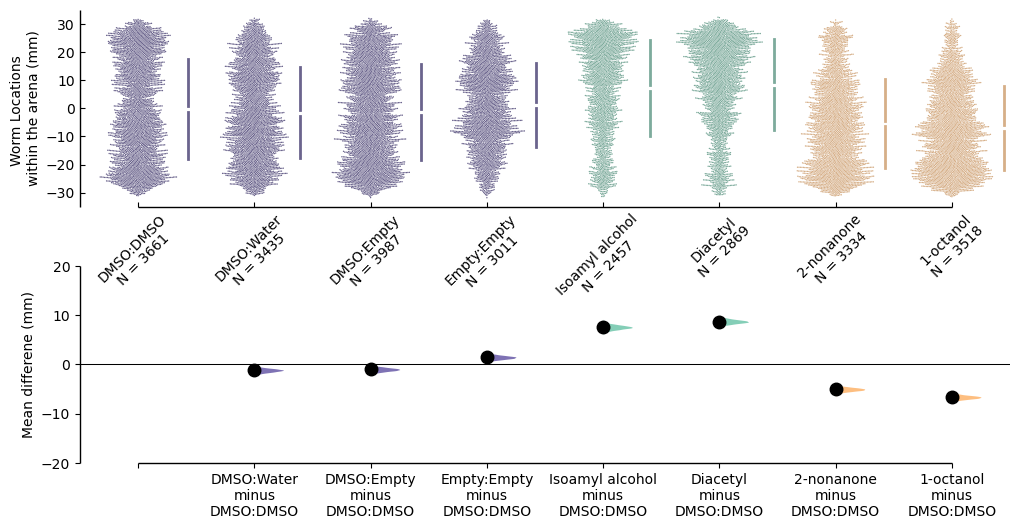

In [15]:
# Generating the plots
mm_refs_plot = mm_refs_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations \nwithin the arena (mm)', 
                                        contrast_label="Mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35), custom_palette=color_dict)

#Accessing plot axes to control plot asthetics
rawswarm_axes = mm_refs_plot.axes[0]
contrast_axes = mm_refs_plot.axes[1]

rawswarm_axes.yaxis.set_tick_params(tickdir='in')
rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)
plt.rcParams['svg.fonttype'] = 'none'

#contrast_axes.remove()

### Calculating the bootstrapped 95% confidence intervals for the mean difference between each condition relative to Empty:Empty

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


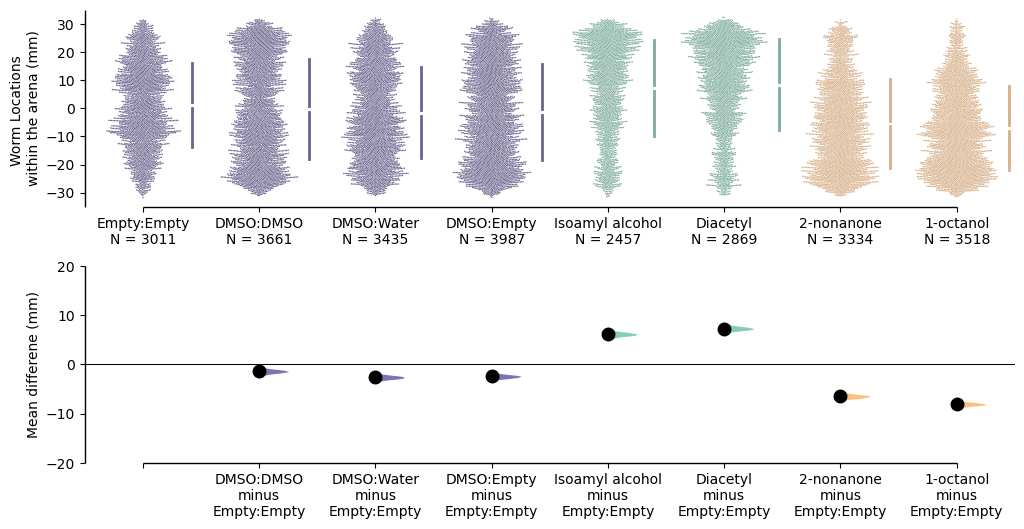

In [16]:
emt_comps=['Empty:Empty', 'DMSO:DMSO', 'DMSO:Water', 'DMSO:Empty', 'Isoamyl alcohol', 'Diacetyl', 
           '2-nonanone', '1-octanol']
emt_obj = dabest.load(mm_df, idx=(emt_comps))
emt_results = emt_obj.mean_diff.results

# Generating the plots
emt_plot = emt_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations \nwithin the arena (mm)', 
                                        contrast_label="Mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35), custom_palette=color_dict)

#Accessing plot axes to control plot asthetics
rawswarm_axes = mm_refs_plot.axes[0]
contrast_axes = mm_refs_plot.axes[1]

rawswarm_axes.yaxis.set_tick_params(tickdir='in')
rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)
plt.rcParams['svg.fonttype'] = 'none'

all_results = pd.concat([results, emt_results])
#all_results.to_csv('C:/Users/Emily/Documents/MS/data/MS_meandiff_results.csv')

In [17]:
for column in mm_df.columns:
    dat = mm_df[column]
    length = len(mm_df[column])- len(mm_df[mm_df[column].isnull()])
    data = mm_df[column][:length]
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

Statistics=0.955, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.959, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.927, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.942, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.927, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.957, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.979, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


In [18]:
subset = ['control', 'test', 'test_N', 'difference', 'bca_low', 'bca_high']

In [19]:
def subset_refs(df, ref):
    dat = df.loc[df['control']== ref]
    dat =dat.sort_values('difference', ascending=False)
    dat = dat.reset_index(drop=True)
    return dat

In [20]:
all_results.head()

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,DMSO:DMSO,DMSO:Water,3661,3435,mean difference,False,-1.196841,95,-2.001330,-0.399546,...,5000,12345,0.0026,5000,3.156111e-03,2.953121,3.241600e-03,2.944850,7.719500e-03,6517520.5
1,DMSO:DMSO,DMSO:Empty,3661,3987,mean difference,False,-1.029665,95,-1.794332,-0.274705,...,5000,12345,0.0102,5000,1.002522e-02,2.575611,9.888302e-03,2.580357,1.180119e-02,7541086.5
2,DMSO:DMSO,Empty:Empty,3661,3011,mean difference,False,1.426300,95,0.663748,2.212645,...,5000,12345,0.0004,5000,3.650965e-04,-3.565939,4.617246e-04,-3.503774,3.203850e-04,5229917.0
3,DMSO:DMSO,Isoamyl alcohol,3661,2457,mean difference,False,7.550210,95,6.654035,8.453426,...,5000,12345,0.0000,5000,2.650220e-61,-16.729687,2.516996e-60,-16.565399,2.505753e-58,3407083.0
4,DMSO:DMSO,Diacetyl,3661,2869,mean difference,False,8.697721,95,7.891948,9.549783,...,5000,12345,0.0000,5000,9.759821e-92,-20.646553,1.011313e-89,-20.399452,3.002242e-83,3790210.5


In [21]:
N2_DMSO_dat = subset_refs(all_results, 'DMSO:DMSO')
N2_ord = N2_DMSO_dat['test']

In [22]:
c = {}
for column in mm_df.columns:

    dat = mm_df[column]
    length = len(mm_df[column])- len(mm_df[mm_df[column].isnull()])
    data = mm_df[column][:length]
    d = {column: data}
    c.update(d)
c
    


{'DMSO:Empty': 0      -11.484333
 1       -5.663500
 2       -4.330000
 3      -10.320167
 4       24.710667
           ...    
 3982   -14.617000
 3983   -19.189000
 3984   -23.739833
 3985    -7.420333
 3986   -18.046000
 Name: DMSO:Empty, Length: 3987, dtype: float64,
 '1-octanol': 0      -24.247833
 1      -16.373833
 2       -7.378000
 3        3.967333
 4        4.369500
           ...    
 3513    18.508833
 3514    15.630167
 3515    24.626000
 3516    16.434500
 3517    11.672000
 Name: 1-octanol, Length: 3518, dtype: float64,
 'Diacetyl': 0      -16.797167
 1       -8.817333
 2      -17.813167
 3       -7.526167
 4      -12.733167
           ...    
 2864   -21.242167
 2865    20.413833
 2866     4.179000
 2867     3.649833
 2868     7.078833
 Name: Diacetyl, Length: 2869, dtype: float64,
 'DMSO:DMSO': 0        7.078833
 1        2.739667
 2      -14.913333
 3       15.397333
 4      -24.099667
           ...    
 3656    -8.711500
 3657   -19.252500
 3658   -13.749167
 3659 

In [30]:
stat, p = levene(c['DMSO:DMSO'], c['DMSO:Empty'], c['DMSO:Water'], c['Empty:Empty'], c['Diacetyl'], 
                 c['Isoamyl alcohol'],c['1-octanol'], c['2-nonanone'])

print(p)

7.768386685475484e-79


In [36]:
print('Null results: ' + str(kruskal(c['DMSO:DMSO'],  c['Empty:Empty'])))
print('Null homogeneity of var: ' + str(levene(c['DMSO:DMSO'], c['DMSO:Empty'], c['DMSO:Water'],c['Empty:Empty'] )))
print('Attraction: ' + str(kruskal(c['Diacetyl'], c['Isoamyl alcohol'])))
print('Attraction varianaces: ' + str(levene(c['Diacetyl'], c['Isoamyl alcohol'])))
print('Repulsion: ' +  str(kruskal(c['1-octanol'], c['2-nonanone'])))
print('Repulsion variances: ' +  str(levene(c['1-octanol'], c['2-nonanone'])))

Null results: KruskalResult(statistic=12.947335522752496, pvalue=0.00032037715466033976)
Null homogeneity of var: LeveneResult(statistic=77.37042945197483, pvalue=1.234364245344246e-49)
Attraction: KruskalResult(statistic=3.5382500913054047, pvalue=0.05996869746010143)
Attraction varianaces: LeveneResult(statistic=13.502673218595378, pvalue=0.00024056616446977073)
Repulsion: KruskalResult(statistic=13.059113743322065, pvalue=0.00030181221293048736)
Repulsion variances: LeveneResult(statistic=21.424776268657745, pvalue=3.7476356724602016e-06)


In [35]:
print('All conditoions: ' + str(kruskal(c['DMSO:DMSO'], c['DMSO:Empty'], c['DMSO:Water'], c['Empty:Empty'], c['Diacetyl'], 
                                        c['Isoamyl alcohol'],c['1-octanol'], c['2-nonanone'])))

All conditoions: KruskalResult(statistic=2114.0073830326414, pvalue=0.0)
